# Carrier injection based Mach-Zehnder modulator

Tidy3D capabilities include the modeling of material properties perturbations due to the presence of free carriers. This provides a convenient way to perform full-wave simulations of electro-optic modulators. In this notebook we demonstrate simulation of a simple pin-junction electro-optic modulator as part of an MZI. For generating free carrier distributions under different voltages we use an open-source package [DEVSIM](https://devsim.org), which can be installed as `pip install devsim`. This example loosely follows the experimental modulator described in [Zhou Liang et al 2011 Chinese Phys. Lett. 28 074202](https://doi.org/10.1088/0256-307X/28/7/074202).

<img src="img/MZI_modulator.png" width="500" alt="Schematic of the MZI modulator">

## Problem Parameters

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import tidy3d as td
from tidy3d import web
import gdstk

import devsim
from devsim.python_packages import model_create, simple_physics

Searching DEVSIM_MATH_LIBS="libopenblas.so:liblapack.so:libblas.so"
Loading "libopenblas.so": ALL BLAS/LAPACK LOADED
Skipping liblapack.so
Skipping libblas.so
loading UMFPACK 5.1 as direct solver


Our simulation setup will consist of an MZI with two arms, one of which has a common pin-junction profile. For combiner and spitter of the signal we use compact y-junction MMIs. The overall geometry and notation used is shown in the following figure.

<img src="img/pn_mzi_cross.png" alt="Modulator Cross-Section"  width="500"/>

<img src="img/pn_mzi_circuit.png" alt="Scheme of MZI Circuit"  width="1000"/>

In [2]:
# modulator cross section parameters (um)
w_core = 0.5
h_core = 0.34
h_slab = 0.1
h_side = 0.34
w_contact = 0.5
x_side = 2.25
x_total = 3
x_i = 0.55
x_p = 1.75
h_contact = 0.01
# note that the height of the metal contact doesn't affect the results
# but devsim requires creating a region representing it
# in order to create a interface between the metal contact and modulator

# modulator doping concentrations (1/cm^3)
conc_p = 1e19
conc_pp = 5e19
conc_n = 1e19
conc_nn = 5e19
# note that concentrations in ++/-- are (conc_p + conc_pp) and (conc_m + conc_mm)

# photonic circuit geometric parameters (um)
y_length_in = 10
y_length_out = 1
y_length_bend = 10
wg_spacing = 3.5
taper_length = 10
pin_length = 200


Auxiliary variable for easier construction of simulations.

In [3]:
mzi_length = 2 * taper_length + pin_length
splitter_length = y_length_in + y_length_out + y_length_bend

z_core = h_core / 2
z_slab = h_slab / 2

## Carrier Distribution

For convenience, we implement a function that uses `devsim` python package to generate electron and hole concentrations in the 2d geometry corresponding to the cross section of the modulator used in this example. It takes in parameters of the cross section profile and voltages to solve at, and returns electron and hole distributions for each requested voltage. This function is built upon methods provided in `python_packages` directory of `devsim` package along the lines of a [one-dimensional diode example](https://devsim.net/examples_diode.html) given in the [DEVSIM documentation](https://devsim.net/index.html). It consists of the following main steps:

1. Creating a mesh using the built-in DEVSIM mesher (supports only Cartesian meshes), including specifying device regions, interfaces between regions and between contacts and regions.
2. Assigning material properties to each region.
3. Assigning doping values over each region.
4. Assigning mathematical models to each region and each interface.
5. Obtaining the solution in the zero bias case.
6. Iterating through requested voltage values and obtaining free carrier distribution for each of them.

In [4]:
from typing import Tuple

def solve_charge(
    w_core: float, 
    h_core: float, 
    h_slab: float, 
    h_side: float, 
    w_contact: Tuple[float, float], 
    h_contact: float,
    x_side: Tuple[float, float], 
    x_total: Tuple[float, float], 
    x_i: Tuple[float, float],
    x_p: Tuple[float, float],
    conc_p: float,
    conc_pp: float,
    conc_n: float,
    conc_nn: float,
    voltages: Tuple[float],
    res: float,
    center: Tuple[float, float, float],
    axis: float,
):
    """
    This function generates electron and hole distributions in a pn (pin) waveguide cross-section.

    Parameters
    ----------
    w_core: width of core region (um)
    h_core: height of core region (um)
    h_slab: height of slab (um) 
    h_side: height of side regions (um)
    w_contact: widths (2) of metal contacts (um)
    h_contact: height of metal contacts (um)
    x_side: distances (2) from modulator center to side ribs (um)  
    x_total: total extents (2) of device in horizontal direction (um) 
    x_i: distances (2) from modulator center to boundaries of lightly doped regions (um)
    x_p: distances (2) from modulator center to boundaries of heavily doped regions (um)
    conc_p: hole concentration of lightly doped region (1/cm^3)
    conc_pp: hole concentration of heavily doped region (1/cm^3)
    conc_n: electron concentration of lightly doped region (1/cm^3)
    conc_nn: electron concentration of heavily doped region (1/cm^3)
    voltages: list of voltages to solve for (V)
    res: spatial resolution (um)
    center: coordinates of modulator base (um)
    axis: modulator orientation in space
    """
    # if mkl is not installed
    from devsim.umfpack.umfshim import local_solver_callback
    devsim.set_parameter(name="direct_solver", value="custom")
    devsim.set_parameter(name="solver_callback", value=local_solver_callback)
    
    device_name = "pin_wg"
    mesh_name = "pin_wg_mesh"

    # convert size into cm
    um_to_cm = 1e-4
    
    w_core_cm = w_core * um_to_cm
    h_core_cm = h_core * um_to_cm
    h_slab_cm = h_slab * um_to_cm
    h_side_cm = h_side * um_to_cm
    w_contact_cm = [w_contact[0] * um_to_cm, w_contact[1] * um_to_cm]
    h_contact_cm = h_contact * um_to_cm
    x_side_cm = [x_side[0] * um_to_cm, x_side[1] * um_to_cm]
    x_total_cm = [x_total[0] * um_to_cm, x_total[1] * um_to_cm]
    
    x_i_cm = [x_i[0] * um_to_cm, x_i[1] * um_to_cm]
    x_p_cm = [x_p[0] * um_to_cm, x_p[1] * um_to_cm]
    
    res_cm = res * um_to_cm

    # tolerance for defining 
    tol = res_cm * 1e-3

    # we will expand device dimensions by a small amount to make sure that numerical round-off
    # errors do not cause interpolation errors near device boundaries when transferring 
    # data from charge solver to optic solver
    expand = tol / 10

    # create mesh
    devsim.create_2d_mesh(mesh=mesh_name)
    devsim.add_2d_mesh_line(mesh=mesh_name, dir="y", pos=0 - expand, ps=res_cm)
    devsim.add_2d_mesh_line(mesh=mesh_name, dir="y", pos=h_slab_cm + expand, ps=res_cm)
    devsim.add_2d_mesh_line(mesh=mesh_name, dir="y", pos=h_core_cm + expand, ps=res_cm)
    if h_side != h_core and h_side != h_slab:
        devsim.add_2d_mesh_line(mesh=mesh_name, dir="y", pos=h_side_cm + expand, ps=res_cm)
    devsim.add_2d_mesh_line(mesh=mesh_name, dir="y", pos=h_side_cm + h_contact_cm, ps=res_cm)
        
    devsim.add_2d_mesh_line(mesh=mesh_name, dir="x", pos=x_total_cm[0] - expand, ps=res_cm)
    devsim.add_2d_mesh_line(mesh=mesh_name, dir="x", pos=x_total_cm[1] + expand, ps=res_cm)
    devsim.add_2d_mesh_line(mesh=mesh_name, dir="x", pos=x_side_cm[0] + expand, ps=res_cm)
    devsim.add_2d_mesh_line(mesh=mesh_name, dir="x", pos=x_side_cm[1] - expand, ps=res_cm)
    devsim.add_2d_mesh_line(mesh=mesh_name, dir="x", pos=-w_core_cm / 2 - expand, ps=res_cm)
    devsim.add_2d_mesh_line(mesh=mesh_name, dir="x", pos=w_core_cm / 2 + expand, ps=res_cm)
    devsim.add_2d_mesh_line(mesh=mesh_name, dir="x", pos=x_total_cm[0] + w_contact_cm[0], ps=res_cm)
    devsim.add_2d_mesh_line(mesh=mesh_name, dir="x", pos=x_total_cm[1] - w_contact_cm[1], ps=res_cm)

    devsim.add_2d_region(mesh=mesh_name, material="Si", region="core", xl=-w_core_cm / 2, xh=w_core_cm / 2, yl=0, yh=h_core_cm, bloat=tol)
    devsim.add_2d_region(mesh=mesh_name, material="Si", region="slab_left", xl=x_side_cm[0], xh=-w_core_cm / 2, yl=0, yh=h_slab_cm, bloat=tol)
    devsim.add_2d_region(mesh=mesh_name, material="Si", region="slab_right", xl=w_core_cm / 2, xh=x_side_cm[1], yl=0, yh=h_slab_cm, bloat=tol)
    devsim.add_2d_region(mesh=mesh_name, material="Si", region="side_left", xl=x_total_cm[0], xh=x_side_cm[0], yl=0, yh=h_side_cm, bloat=tol)
    devsim.add_2d_region(mesh=mesh_name, material="Si", region="side_right", xl=x_side_cm[1], xh=x_total_cm[1], yl=0 , yh=h_side_cm, bloat=tol)
    devsim.add_2d_region(mesh=mesh_name, material="metal", region="metal_right", xl=x_total_cm[1] - w_contact_cm[1], xh=x_total_cm[1], yl=h_side_cm, yh=h_side_cm + h_contact_cm, bloat=tol)
    devsim.add_2d_region(mesh=mesh_name, material="metal", region="metal_left", xl=x_total_cm[0], xh=x_total_cm[0] + w_contact_cm[0], yl=h_side_cm, yh=h_side_cm + h_contact_cm, bloat=tol)
    
    devsim.add_2d_interface(mesh=mesh_name, name="side/slab", region0="side_left", region1="slab_left", xl=x_side_cm[0], xh=x_side_cm[0], yl=0, yh=h_slab_cm)
    devsim.add_2d_interface(mesh=mesh_name, name="slab/core", region0="slab_left", region1="core", xl=-w_core_cm / 2, xh=-w_core_cm / 2, yl=0, yh=h_slab_cm)
    devsim.add_2d_interface(mesh=mesh_name, name="core/slab", region0="core", region1="slab_right", xl=w_core_cm / 2, xh=w_core_cm / 2, yl=0, yh=h_slab_cm)
    devsim.add_2d_interface(mesh=mesh_name, name="slad/side", region0="slab_right", region1="side_right", xl=x_side_cm[1], xh=x_side_cm[1], yl=0, yh=h_slab_cm)
    
    devsim.add_2d_contact(mesh=mesh_name, name="left_contact", material="metal", region="side_left", yl=h_side_cm, yh=h_side_cm, xl=x_total_cm[0], xh=x_total_cm[0] + w_contact_cm[0], bloat=tol)
    devsim.add_2d_contact(mesh=mesh_name, name="right_contact", material="metal", region="side_right", yl=h_side_cm, yh=h_side_cm, xl=x_total_cm[1] - w_contact_cm[1], xh=x_total_cm[1], bloat=tol)

    devsim.finalize_mesh(mesh=mesh_name)
    devsim.create_device(mesh=mesh_name, device=device_name)

    si_regions = ["core", "slab_left", "slab_right", "side_left", "side_right"]
    
    # set material parameters
    for region in si_regions:
        simple_physics.SetSiliconParameters(device_name, region, 300)

    # set doping
    p_expr = f"{conc_p:1.6e}*step({x_i_cm[0]:1.6e}-x) + {conc_pp:1.6e}*step({x_p_cm[0]:1.6e}-x)"
    n_expr = f"{conc_n:1.6e}*step(x-{x_i_cm[1]:1.6e}) + {conc_nn:1.6e}*step(x-{x_p_cm[1]:1.6e})"

    for region in si_regions:
        model_create.CreateNodeModel(device_name, region, "Acceptors", p_expr)
        model_create.CreateNodeModel(device_name, region, "Donors", n_expr)
        model_create.CreateNodeModel(device_name, region, "NetDoping", "Donors-Acceptors")
    
    # create potential only model
    for region in si_regions:
        simple_physics.CreateSolution(device_name, region, "Potential")
        simple_physics.CreateSiliconPotentialOnly(device_name, region)
        
    simple_physics.CreateSiliconPotentialOnlyContact(device_name, "side_left", "left_contact")
    simple_physics.CreateSiliconPotentialOnlyContact(device_name, "side_right", "right_contact")

    # set bias
    devsim.set_parameter(device=device_name, name=simple_physics.GetContactBiasName("left_contact"), value="0.0")
    devsim.set_parameter(device=device_name, name=simple_physics.GetContactBiasName("right_contact"), value="0.0")

    # initial solution
    devsim.solve(type="dc", absolute_error=1e10, relative_error=1e-10, maximum_iterations=50)
        
    for region in si_regions:        
        model_create.CreateSolution(device_name, region, "Electrons")
        model_create.CreateSolution(device_name, region, "Holes")

        # create initial guess from dc only solution
        devsim.set_node_values(device=device_name, region=region, name="Electrons", init_from="IntrinsicElectrons")
        devsim.set_node_values(device=device_name, region=region, name="Holes", init_from="IntrinsicHoles")

        # Set up equations
        simple_physics.CreateSiliconDriftDiffusion(device_name, region)

    simple_physics.CreateSiliconDriftDiffusionAtContact(device_name, "side_left", "left_contact")
    simple_physics.CreateSiliconDriftDiffusionAtContact(device_name, "side_right", "right_contact")
        
    for interface in devsim.get_interface_list(device=device_name):
        simple_physics.CreateSiliconSiliconInterface(
            device=device_name, interface=interface
        )
        
    devsim.solve(type="dc", absolute_error=1e10, relative_error=1e-10, maximum_iterations=50)

    normal_pos = center.pop(axis)

    electrons_datas = []
    holes_datas = []

    # iterate through and solve for each voltage
    for v in voltages:
        # set new voltage
        devsim.set_parameter(device=device_name, name=simple_physics.GetContactBiasName("left_contact"), value=f"{v:1.6e}")

        # solve
        devsim.solve(type="dc", absolute_error=1e10, relative_error=1e-10, maximum_iterations=50)

        # load resulting electron and hole distribution region 
        # and combine them into a single data entities
        points = np.ndarray((0, 2))
        cells = np.ndarray((0, 3), dtype=int)
        values_electrons = np.ndarray((0))
        values_holes = np.ndarray((0))

        for region in si_regions:
            # read carrier distributions values
            part_electrons = np.array(devsim.get_node_model_values(device=device_name, region=region, name="Electrons"))
            part_holes = np.array(devsim.get_node_model_values(device=device_name, region=region, name="Holes"))
            
            # read mesh connectivity
            part_cells = np.array(devsim.get_element_node_list(device=device_name, region=region))
            
            # read mesh nodes coordinates
            part_xs = np.array(devsim.get_node_model_values(device=device_name, region=region, name="x"))
            part_ys = np.array(devsim.get_node_model_values(device=device_name, region=region, name="y"))
            part_points = np.transpose([part_xs, part_ys])

            # scale and shift node coordinates
            part_points = part_points / um_to_cm + center

            # gather data in single arrays
            num_points_old = len(points)
            values_electrons = np.concatenate((values_electrons, part_electrons))
            values_holes = np.concatenate((values_holes, part_holes))
            points = np.concatenate((points, part_points))
            cells = np.concatenate((cells, num_points_old + part_cells))

        # convert loaded data into TriangularGridDataset
        points_xr = td.PointDataArray(points, dims=["index", "axis"])
        cells_xr = td.CellDataArray(cells, dims=["cell_index", "vertex_index"])

        electrons_xr = td.IndexedDataArray(values_electrons, dims=["index"])
        holes_xr = td.IndexedDataArray(values_holes, dims=["index"])
        
        electrons_data = td.TriangularGridDataset(points=points_xr, cells=cells_xr, values=electrons_xr, normal_pos=normal_pos, normal_axis=axis)
        holes_data = td.TriangularGridDataset(points=points_xr, cells=cells_xr, values=holes_xr, normal_pos=normal_pos, normal_axis=axis)

        # append to lists that will be returned 
        electrons_datas.append(electrons_data)
        holes_datas.append(holes_data)

    devsim.reset_devsim()

    return electrons_datas, holes_datas

Let us generate free carrier distributions for forward bias values up to 1.2 V with a step of 0.1 V using spatial resolution of 0.005 um.

In [5]:
%%capture
devsim.reset_devsim()

res = 0.005
voltages = np.arange(13) * 0.1

electrons_data, holes_data = solve_charge(
    w_core=w_core, 
    h_core=h_core, 
    h_slab=h_slab, 
    h_side=h_side, 
    w_contact=[w_contact, w_contact], 
    h_contact=h_contact,
    x_side=[-x_side, x_side], 
    x_total=[-x_total, x_total], 
    x_i=[-x_i, x_i], 
    x_p=[-x_p, x_p], 
    conc_p=conc_p,
    conc_pp=conc_pp,
    conc_n=conc_n,
    conc_nn=conc_nn,
    voltages=voltages,
    res=res,
    center=[0, wg_spacing / 2, 0],
    axis=0,
)

In [6]:
carrier_data = list(zip(voltages, electrons_data, holes_data))

Visualization of electron distributions for zero and 1.2 V biases.

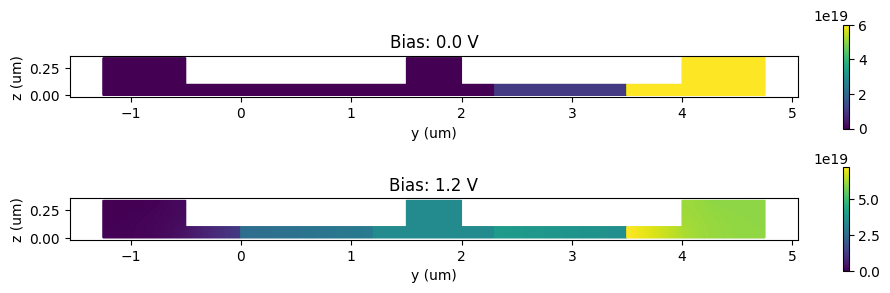

In [7]:
_, ax = plt.subplots(2, 1, figsize=(10, 3))

for ind, (volt, electrons, _) in enumerate([carrier_data[0], carrier_data[-1]]):
    electrons.plot(grid=False, ax=ax[ind])
    ax[ind].set_title(f"Bias: {volt:1.1f} V")
    ax[ind].set_xlabel("y (um)")
    ax[ind].set_ylabel("z (um)")

plt.tight_layout()
plt.show()

## Optic Simulations

Having obtained free carrier solutions in the modulator cross section we can now turn to setting up optic simulation that will use these results.

### Mediums with Charge Perturbations
First, we define optic mediums with charge perturbation models. For simplicity, we will use non-dispersive material descriptions. Thus, we start from obtaining permittivity and conductivity of Si at the wavelength of interest.

In [8]:
wvl_um = 1.55
freq0 = td.C_0 / wvl_um

si = td.material_library['cSi']['Li1993_293K']
n_si, k_si = si.nk_model(frequency=td.C_0/np.array(wvl_um))

# convert to permittivity and conductivity
permittivity_si, conductivity_si = td.Medium.nk_to_eps_sigma(n=n_si, k=k_si, freq=freq0)

We will use empiric relationships presented in [M. Nedeljkovic, R. Soref and G. Z. Mashanovich, "Free-Carrier Electrorefraction and Electroabsorption Modulation Predictions for Silicon Over the 1–14-  μm  Infrared Wavelength Range," IEEE Photonics Journal, vol. 3, no. 6, pp. 1171-1180, Dec. 2011](https://doi.org/10.1109/JPHOT.2011.2171930), that state that changes in $n$ and $k$ of Si can be described by formulas
$$ - \Delta n = \frac{dn}{dN_e}(\lambda) (\Delta N_e)^{\alpha(\lambda)} + \frac{dn}{dN_h}(\lambda) (\Delta N_h)^{\beta(\lambda)}$$
$$ \Delta \left( \frac{4 \pi k}{\lambda} \right) = \frac{dk}{dN_e}(\lambda) (\Delta N_e)^{\gamma(\lambda)} + \frac{dk}{dN_h}(\lambda) (\Delta N_h)^{\delta(\lambda)}$$
where $\Delta N_e$ and $\Delta N_h$ are electron and hole densities, and parameters have the following values for wavelength of 1.55 $\mu$m:

| $\lambda$ | $\frac{dn}{dN_e}$ | $\alpha$ | $\frac{dn}{dN_h}$ | $\beta$ | $\frac{dk}{dN_e}$ | $\gamma$ | $\frac{dk}{dN_h}$ | $\delta$ |
| --------- | ----------------- | ------- | ------------------ | ------- | ----------------- | -------- | ----------------- | -------- |
| $1.55$ | $5.40 \times 10^{-22}$ | $1.011$ | $1.53 \times 10^{-18}$ | $0.838$ | $8.88 \times 10^{-21}$ | $1.167$ | $5.84 \times 10^{-20}$ | $1.109$ | 

In [9]:
wvl_si_data = 1.55

ne_coeff = -5.4e-22
ne_pow = 1.011

nh_coeff = -1.53e-18
nh_pow = 0.838

k_factor = wvl_si_data * 1e-4 / 4 / np.pi  # factor for conversion from absorption coefficient into k

ke_coeff = k_factor * 8.88e-21
ke_pow = 1.167

kh_coeff = k_factor * 5.84e-20
kh_pow = 1.109

Given the nonlinear character of these dependencies we will incorporate them as sampled function on a rectangular grid formed by electron and hole density values. Specifically, we will sample given $n$ and $k$ dependencies in the electron and hole density ranges up to $10^{20}$ 1/cm$^3$.

In [10]:
Ne_range = np.concatenate(([0], np.logspace(15, 20, 20)))
Nh_range = np.concatenate(([0], np.logspace(15, 20, 21)))

Ne_mesh, Nh_mesh = np.meshgrid(Ne_range, Nh_range, indexing='ij')

wvl_ind = 1

n_mesh = n_si + ne_coeff * Ne_mesh ** ne_pow + nh_coeff * Nh_mesh ** nh_pow
k_mesh = k_si + ke_coeff * Ne_mesh ** ke_pow + kh_coeff * Nh_mesh ** kh_pow

Now we convert sampled values of $n$ and $k$ into permittivity $\varepsilon$ and conductivity $\sigma$ values, and assemble a non-dispersive medium with perturbations (`PerturbationMedium`).

In [11]:
eps_mesh, sigma_mesh = td.Medium.nk_to_eps_sigma(n=n_mesh, k=k_mesh, freq=freq0)

deps_data = td.ChargeDataArray(eps_mesh - permittivity_si, coords=dict(n=Ne_range, p=Nh_range))
dsigma_data = td.ChargeDataArray(sigma_mesh - conductivity_si, coords=dict(n=Ne_range, p=Nh_range))

permittivity_si_charge = td.CustomChargePerturbation(perturbation_values=deps_data)
conductivity_si_charge = td.CustomChargePerturbation(perturbation_values=dsigma_data)

permittivity_si_perturbation = td.ParameterPerturbation(
    charge=permittivity_si_charge,
)

conductivity_si_perturbation = td.ParameterPerturbation(
    charge=conductivity_si_charge,
)

si_perturb = td.PerturbationMedium(
    permittivity=permittivity_si,
    conductivity=conductivity_si,
    permittivity_perturbation=permittivity_si_perturbation,
    conductivity_perturbation=conductivity_si_perturbation,
)

Additionally, we define medium for undoped Si regions and for SiO2 BOX/cladding.

In [12]:
si_non_perturb = td.Medium(
    permittivity=permittivity_si,
    conductivity=conductivity_si,
)

sio2 = td.Medium(permittivity=1.444 ** 2)

### Circuits Structures
For generating the entire circuit we use helper functions for creating a single waveguide and a waveguide y-junction (see tutorials [Defining common integrated photonic components](https://www.flexcompute.com/tidy3d/examples/notebooks/PICComponents/) and [Waveguide Y junction](https://www.flexcompute.com/tidy3d/examples/notebooks/YJunction/)).

In [13]:
def make_waveguide(
    x0, y0, z0, x1, y1, wg_width_0, wg_width_1, wg_thickness, medium, sidewall_angle=0
):
    """
    This function defines a linear waveguide taper and returns the tidy3d structure of it.

    Parameters
    ----------
    x0: x coordinate of the waveguide starting position (um)
    y0: y coordinate of the waveguide starting position (um)
    z0: z coordinate of the waveguide bottom surface (um)
    x1: x coordinate of the waveguide end position (um)
    y1: y coordinate of the waveguide end position (um)
    wg_width_0: width of the waveguide in the beginning (um)
    wg_width_1: width of the waveguide in the end (um)
    wg_thickness: thickness of the waveguide (um)
    medium: medium of the waveguide
    sidewall_angle: side wall angle of the waveguide (rad)
    """
    cell = gdstk.Cell("taper")  # define a gds cell

    path = gdstk.RobustPath((x0, y0), wg_width_0, layer=1, datatype=0)  # define a path
    path.segment((x1, y1), wg_width_1)

    cell.add(path)  # add path to the cell

    # define geometry from the gds cell
    taper_geo = td.PolySlab.from_gds(
        cell,
        gds_layer=1,
        axis=2,
        slab_bounds=(z0, z0 + wg_thickness),
        sidewall_angle=sidewall_angle,
    )

    # define tidy3d structure of the bend
    taper = td.Structure(geometry=taper_geo[0], medium=medium)

    return taper

In [14]:
def make_y_junction(
    x0, y0, z0, wg_thickness, wg_spacing, wg_length_in, wg_length_out, bend_length, direction, medium, sidewall_angle=0,
):    
    """
    This function defines a waveguide y junction and returns the tidy3d structure of it.
    The width of waveguides are set to 500 nm.

    Parameters
    ----------
    x0: x coordinate of the output waveguides ends (um)
    y0: y coordinate of the y junction center (um)
    z0: z coordinate of the bottom surface (um)
    wg_thickness: thickness of the waveguides (um)
    wg_spacing: spacing between output waveguides (center-to-center) (um)
    wg_length_in: length of the input waveguide and y-junction together, cannot be less than 2 (um)
    wg_length_out: length of straight output waveguides (um)
    bend_length: length of s-bends (um)
    direction: direction of splitting (1: from left to right, -1: from right to left)
    medium: medium of the waveguide
    sidewall_angle: side wall angle of the waveguide (rad)
    """
    # parameters of y junction
    
    # width of the 13 segments
    w1 = 0.5
    w2 = 0.5
    w3 = 0.6
    w4 = 0.7
    w5 = 0.9
    w6 = 1.26
    w7 = 1.4
    w8 = 1.4
    w9 = 1.4
    w10 = 1.4
    w11 = 1.31
    w12 = 1.2
    w13 = 1.2
    
    l_junction = 2  # length of the junction
    
    if wg_length_in < l_junction:
        raise ValueError(f"'wg_length_in' cannot be less than {l_junction}.")

    # auxiliary variables
    h_bend = (wg_spacing - w13 + w1) / 2  # vertical offset of the waveguide bend

    # positions between output waveguides / s-bends / y-junction / input waveguide
    x1 = x0 - direction * wg_length_out
    x2 = x1 - direction * y_length_bend
    x3 = x2 - direction * l_junction
    x4 = x2 - direction * wg_length_in    

    slab_bounds = (z0, z0 + wg_thickness)

    # straight input waveguide
    wg_in = td.PolySlab(
        vertices=[(x4, y0 - w1 / 2), (x3, y0 - w1 / 2), (x3, y0 + w1 / 2), (x4, y0 + w1 / 2)], 
        axis=2, 
        slab_bounds=slab_bounds, 
        sidewall_angle=sidewall_angle,
    )

    # Y junction
    x = np.linspace(x3, x2, 13)  # x coordinates of the top edge vertices
    y = np.array(
        [w1, w2, w3, w4, w5, w6, w7, w8, w9, w10, w11, w12, w13]
    )  # y coordinates of the top edge vertices
    
    # using concatenate to include bottom edge vertices
    x = np.concatenate((x, np.flipud(x)))
    y = y0 + np.concatenate((y / 2, -np.flipud(y / 2)))
    
    # stacking x and y coordinates to form vertices pairs
    vertices = np.transpose(np.vstack((x, y)))
    
    junction = td.PolySlab(vertices=vertices, axis=2, slab_bounds=slab_bounds, sidewall_angle=sidewall_angle)

    # bends and output waveguides
    x = np.linspace(
        x2, x1, 100
    )  # x coordinates of the top edge vertices
    
    y = (
        np.abs(x - x2) * h_bend / y_length_bend
        - h_bend * np.sin(2 * np.pi * np.abs(x - x2) / y_length_bend) / (np.pi * 2)
        + w13 / 2 - w1 / 2
    )  # y coordinates of the top edge vertices
    
    # adding the last point to include the straight waveguide at the output
    x = np.append(x, x0)
    y = y0 + np.append(y, y[-1])
    
    # add path to the cell
    cell = gdstk.Cell("bends")
    cell.add(gdstk.FlexPath(x + 1j * y, w1, layer=1, datatype=0))  # top waveguide bend
    cell.add(gdstk.FlexPath(x - 1j * y, w1, layer=1, datatype=0))  # bottom waveguide bend
    
    wg_bends = td.PolySlab.from_gds(
        cell,
        gds_layer=1,
        axis=2,
        slab_bounds=slab_bounds,
        sidewall_angle=sidewall_angle,
    )

    # combine all components into a single struture using GeometryGroup
    y_junction = td.Structure(
        geometry=td.GeometryGroup(geometries=[wg_in, junction] + wg_bends), 
        medium=medium,
    )

    return y_junction

Additionally, we create convenience functions to create a rib waveguide and a strip-to-rib taper.

In [15]:
def make_strip_rib_taper(
    x0, y0, z0, x1, y1, core_width, slab_width, core_thickness, slab_thickness, medium, sidewall_angle=0
):
    """
    This function defines a linear waveguide taper and returns the tidy3d structure of it.

    Parameters
    ----------
    x0: x coordinate of the waveguide starting position (um)
    y0: y coordinate of the waveguide starting position (um)
    z0: z coordinate of the waveguide bottom surface (um)
    x1: x coordinate of the waveguide end position (um)
    y1: y coordinate of the waveguide end position (um)
    core_width: width of the waveguide core (um)
    slab_width: width of the slab (um)
    core_thickness: thickness of the waveguide core (um)
    slab_thickness: thickness of the slab (um)
    medium: medium of the waveguide
    sidewall_angle: side wall angle of the waveguide (rad)
    """

    # core
    core = make_waveguide(
        x0=x0, 
        y0=y0, 
        z0=z0, 
        x1=x1, 
        y1=y1, 
        wg_width_0=core_width, 
        wg_width_1=core_width, 
        wg_thickness=core_thickness, 
        medium=medium,
        sidewall_angle=sidewall_angle,
    )

    # slab
    slab = make_waveguide(
        x0=x0, 
        y0=y0, 
        z0=z0, 
        x1=x1, 
        y1=y1, 
        wg_width_0=core_width, 
        wg_width_1=slab_width, 
        wg_thickness=slab_thickness, 
        medium=medium,
        sidewall_angle=sidewall_angle,
    )

    return [core, slab]

In [16]:
def make_rib_waveguide(
    x0, y0, z0, x1, y1, core_width, slab_width, side_width, core_thickness, slab_thickness, side_thickness, medium, sidewall_angle=0
):
    """
    This function defines a linear waveguide taper and returns the tidy3d structure of it.

    Parameters
    ----------
    x0: x coordinate of the waveguide starting position (um)
    y0: y coordinate of the waveguide starting position (um)
    z0: z coordinate of the waveguide bottom surface (um)
    x1: x coordinate of the waveguide end position (um)
    y1: y coordinate of the waveguide end position (um)
    core_width: width of the waveguide core (um)
    slab_width: width of the slab (um)
    side_width: width of the side ribs (um)
    core_thickness: thickness of the waveguide core (um)
    slab_thickness: thickness of the slab (um)
    side_thickness: thickness of the side ribs (um)
    medium: medium of the waveguide
    sidewall_angle: side wall angle of the waveguide (rad)
    """
    
    # modulator
    slab = make_waveguide(
        x0=x0, 
        y0=y0, 
        z0=z0, 
        x1=x1, 
        y1=y1, 
        wg_width_0=slab_width, 
        wg_width_1=slab_width, 
        wg_thickness=slab_thickness,
        medium=medium,
        sidewall_angle=sidewall_angle,
    )
    
    core = make_waveguide(
        x0=x0, 
        y0=y0, 
        z0=z0, 
        x1=x1, 
        y1=y1, 
        wg_width_0=core_width, 
        wg_width_1=core_width, 
        wg_thickness=core_thickness,
        medium=medium,
        sidewall_angle=sidewall_angle,
    )
    
    y_side_top = y0 + (slab_width / 2 - side_width / 2)
    y_side_bottom = y0 - (slab_width / 2 - side_width / 2)
    
    side_top = make_waveguide(
        x0=x0, 
        y0=y_side_top, 
        z0=z0, 
        x1=x1, 
        y1=y_side_top,
        wg_width_0=side_width, 
        wg_width_1=side_width, 
        wg_thickness=side_thickness, 
        medium=medium,
        sidewall_angle=sidewall_angle,
    )
    
    side_bottom = make_waveguide(
        x0=x0, 
        y0=y_side_bottom, 
        z0=z0, 
        x1=x1, 
        y1=y_side_bottom,
        wg_width_0=side_width, 
        wg_width_1=side_width, 
        wg_thickness=side_thickness, 
        medium=medium,
        sidewall_angle=sidewall_angle,
    )

    return [core, slab, side_top, side_bottom]

Now we need to create necessary components. Note that we use the medium with perturbation models only for the modulator section (`pin_wg`) as the rest of the structures are assumed to be undoped.

In [17]:
# input coupler
coupler_in = make_y_junction(
    x0=-mzi_length / 2,
    y0=0,
    z0=0,
    wg_thickness=h_core,
    wg_spacing=wg_spacing,
    wg_length_in=y_length_in,
    wg_length_out=y_length_out,
    bend_length=y_length_bend,
    direction=1,
    medium=si_non_perturb,
    sidewall_angle=0,
)

# output coupler
coupler_out = make_y_junction(
    x0=mzi_length / 2,
    y0=0,
    z0=0,
    wg_thickness=h_core,
    wg_spacing=wg_spacing,
    wg_length_in=y_length_in,
    wg_length_out=y_length_out,
    bend_length=y_length_bend,
    direction=-1,
    medium=si_non_perturb,
    sidewall_angle=0,
)

# bottom arm
bot_arm = make_waveguide(
    x0=-mzi_length / 2, 
    y0=-wg_spacing / 2, 
    z0=0, 
    x1=mzi_length / 2, 
    y1=-wg_spacing / 2, 
    wg_width_0=w_core, 
    wg_width_1=w_core, 
    wg_thickness=h_core, 
    medium=si_non_perturb,
    sidewall_angle=0,
)

# top arm: taper in
taper_in = make_strip_rib_taper(
    x0=-mzi_length / 2, 
    y0=wg_spacing / 2, 
    z0=0, 
    x1=-pin_length / 2, 
    y1=wg_spacing / 2, 
    core_width=w_core, 
    slab_width=2 * x_side, 
    core_thickness=h_core, 
    slab_thickness=h_slab, 
    medium=si_non_perturb,
    sidewall_angle=0,
)

# top arm: PIN region
pin_wg = make_rib_waveguide(
    x0=-pin_length / 2, 
    y0=wg_spacing / 2, 
    z0=0, 
    x1=pin_length / 2, 
    y1=wg_spacing / 2, 
    core_width=w_core, 
    slab_width=2 * x_total,
    side_width=x_total - x_side,
    core_thickness=h_core, 
    slab_thickness=h_slab, 
    side_thickness=h_side,
    medium=si_perturb,
    sidewall_angle=0,
)


# top arm: taper out
taper_out = make_strip_rib_taper(
    x0=mzi_length / 2, 
    y0=wg_spacing / 2, 
    z0=0, 
    x1=pin_length / 2, 
    y1=wg_spacing / 2, 
    core_width=w_core, 
    slab_width=2 * x_side, 
    core_thickness=h_core, 
    slab_thickness=h_slab, 
    medium=si_non_perturb,
    sidewall_angle=0,
)

Before proceeding further into creating an optic simulation, we can combine created structures into a `Scene` object for visualization purposes.

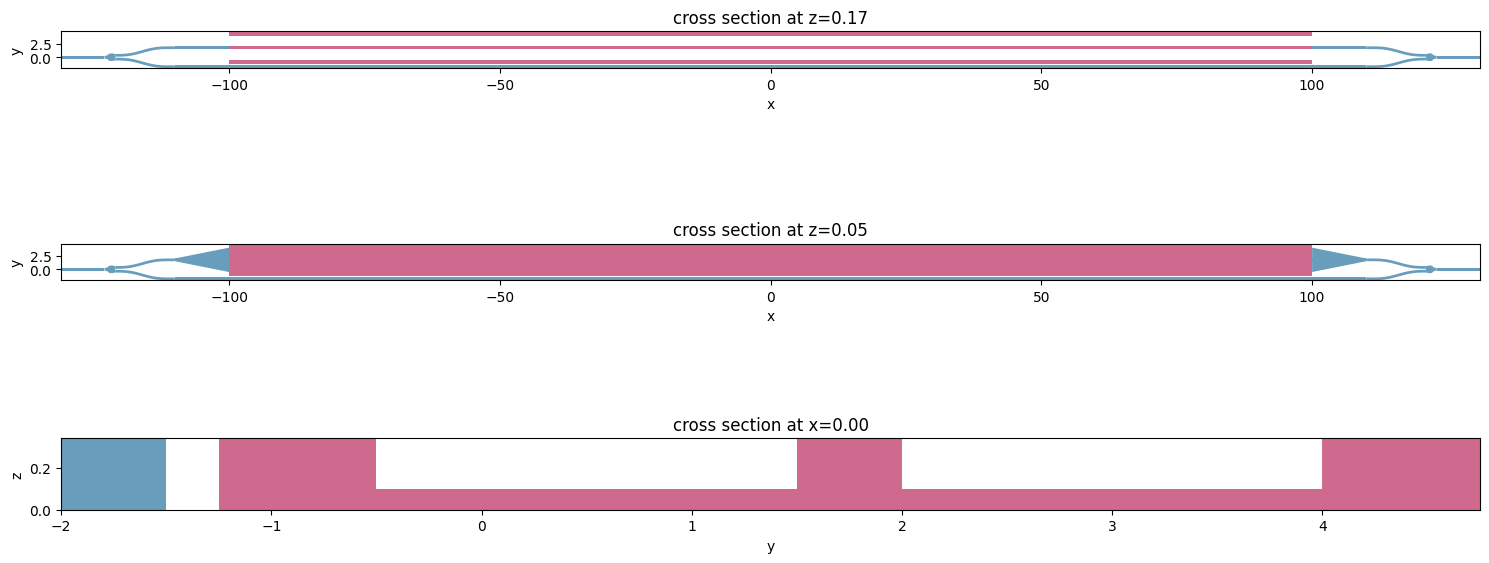

In [18]:
scene = td.Scene(
    structures=[coupler_in, coupler_out, bot_arm] + taper_in + pin_wg + taper_out, 
    medium=sio2,
)

_, ax = plt.subplots(3, 1, figsize=(15, 7))
scene.plot(z=z_core, ax=ax[0])
scene.plot(z=z_slab, ax=ax[1])
scene.plot(x=0, ax=ax[2])

plt.tight_layout()
plt.show()


### Optic Sources and Monitors
Having inspected the geometry we now continue to define other components of an optic simulation. First, we define several auxiliary variables corresponding to:
- SiO2 buffer around the circuit,
- reduction of simulation in x direction,
- location and size of source injection and monitor ports,
- width of the injected pulse, and
- frequencies at which to measure output signals.

In [19]:
buffer = 1
dx = 6

port_x = mzi_length / 2 + splitter_length - dx - 1
port_y = 0
port_z = z_core

port_size = (0, 3, 2)

fwidth = freq0 / 5
freqs = np.linspace(freq0 - fwidth / 10, freq0 + fwidth / 10, 201)
wvls = td.C_0 / freqs

The propagation of EM pulse in the circuit is triggered by a `ModeSource`.

In [20]:
src = td.ModeSource(
    center=(-port_x - 0.5, port_y, port_z), 
    size=port_size, 
    direction="+", 
    mode_index=0, 
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
)

We will measure mode decompositions in the input port and two output ports. Additionally, we will sample field distribution on the horizontal plane passing through the circuit's center.

In [21]:
mnt_in = td.ModeMonitor(center=(-port_x, port_y, port_z), size=port_size, freqs=freqs, mode_spec=td.ModeSpec(num_modes=3), name="in")
mnt_out = td.ModeMonitor(center=(port_x, port_y, port_z), size=port_size, freqs=freqs, mode_spec=td.ModeSpec(num_modes=3), name="out")
mnt_field = td.FieldMonitor(center=(0, 0, z_core), size=(td.inf, td.inf, 0), freqs=[freq0], name="field")

### Simulation Assembly

In [22]:
sim_size = (scene.size[0] - 2 * dx, scene.size[1] + 2 * buffer, scene.size[2] + 2 * buffer)
sim = td.Simulation(
    center=scene.center,
    size=sim_size,
    sources=[src],
    monitors=[mnt_in, mnt_out, mnt_field],
    structures=scene.structures,
    run_time=6e-11,
)

Let us perform another visual inspection to ensure the right placement of monitors and sources.

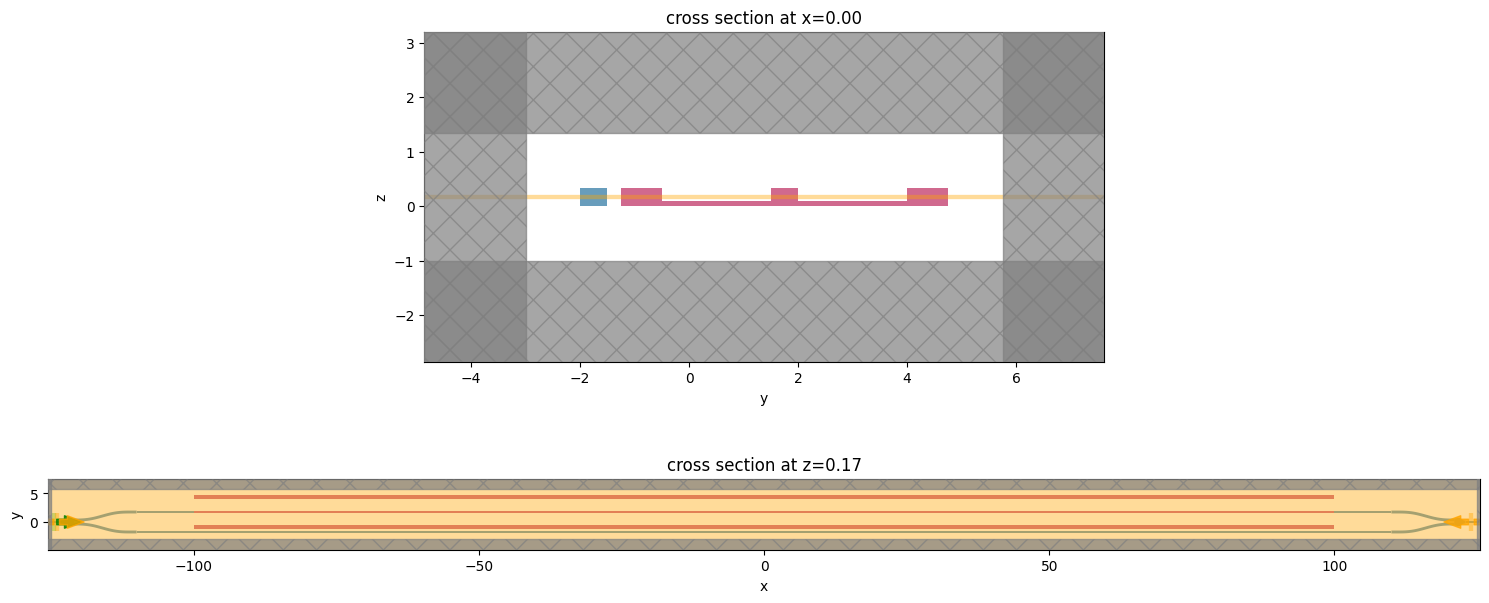

In [23]:
_, ax = plt.subplots(2, 1, figsize=(15, 7))
sim.plot(x=sim.center[0], ax=ax[0])
sim.plot(z=sim.center[2], ax=ax[1])

plt.tight_layout()
plt.show()

This can also be done using a three dimensional plotting functionality.

In [24]:
sim.plot_3d(width=800, height=600)

### Applying Carrier Distributions
At this point we have created an optic simulation that contains materials with charge perturbation models, however no electron and hole distributions have been provided to it. That is, when we submit such a simulation for solving, all mediums with perturbation models will be considered as regular materials with no perturbations applied. In our case, this corresponds to the case of undoped materials.

To obtain simulations in which perturbation models are sampled against provided carrier densities one can use a convenience method `.perturbed_mediums_copy()`. In the current Tidy3D version, one must provide carrier densities in the form of Cartesian arrays. Thus, we first define a Cartesian grid to transfer carrier distributions to based on the simulation grid without perturbations.

In [25]:
def apply_charge(electrons_data, holes_data):
    perturbed_sims = []
    for e_data, h_data in zip(electrons_data, holes_data):
        perturbed_sims.append(sim.perturbed_mediums_copy(electron_density=e_data, hole_density=h_data))
    return perturbed_sims

perturbed_sims = apply_charge(electrons_data, holes_data)

The difference in the permittivity values in the modulator cross-section compared to the undoped case can be visualized as following.

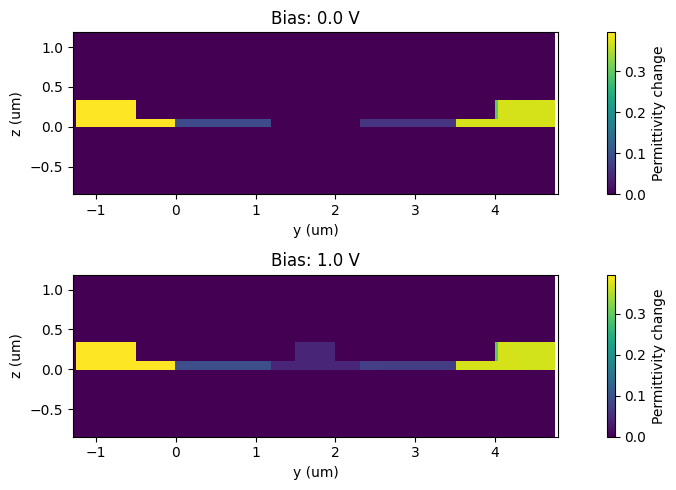

In [27]:
_, ax = plt.subplots(2, 1, figsize=(10, 5))
eps_undoped = sim.epsilon(box=td.Box(center=(0, wg_spacing / 2, port_z), size=(0, 6, 2)))

for ax_ind, ind in enumerate([0, 10]):
    eps_doped = perturbed_sims[ind].epsilon(box=td.Box(center=(0, wg_spacing / 2, port_z), size=(0, 6, 2)))
    eps_diff = np.abs(np.real(eps_doped - eps_undoped.interp(y=eps_doped.y, z=eps_doped.z)))
    eps_diff.name = "Permittivity change"
    eps_diff.plot(x="y", ax=ax[ax_ind])
    ax[ax_ind].set_aspect("equal")
    ax[ax_ind].set_title(f"Bias: {voltages[ind]:1.1f} V")
    ax[ax_ind].set_xlabel("y (um)")
    ax[ax_ind].set_ylabel("z (um)")

plt.tight_layout()
plt.show()

### Waveguide Mode Analysis

before proceeding to full-wave simulations one can investigate the influence of applied voltage on the propagation index of waveguide modes in the modulator.

In [28]:
from tidy3d.plugins.mode import ModeSolver
from tidy3d.plugins.mode.web import run as run_mode

Let us define a plane for which waveguide modes will be calculated.

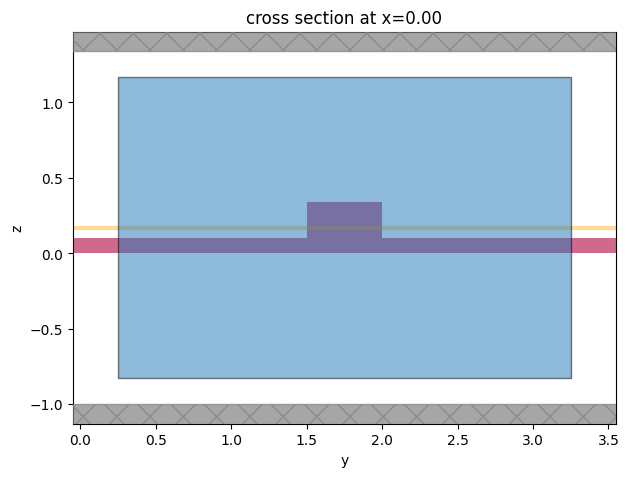

In [29]:
mode_plane = td.Box(center=(0, wg_spacing / 2, port_z), size=port_size)

# visualize
ax = sim.plot(x=mode_plane.center[0])
mode_plane.plot(x=mode_plane.center[0], ax=ax, alpha=0.5)
plt.show()

Create a mode solver specification for each carrier distribution. We will consider only the first mode at 11 different frequencies. Also, given that the anticipated changes are small, double precision is turned on for mode solving.

In [30]:
mode_solvers = []
for psim in perturbed_sims:
    ms = ModeSolver(
        simulation=psim,
        plane=mode_plane,
        freqs=np.linspace(freqs[0], freqs[-1], 11),
        mode_spec=td.ModeSpec(num_modes=1, precision="double"),
    )
    mode_solvers.append(ms)

Perform calculation on our servers. Note that since the associated simulation objects contain custom medium data, they are automatically reduced to the mode solver plane for optimizing uploading/downloading data. Setting `reduce_simulation=True` will silence the associated warning.

In [31]:
ms_data = []
for ms in mode_solvers:
    md = run_mode(ms)
    ms_data.append(md)

14:37:15 CST WARNING: The associated 'Simulation' object contains custom        
             mediums. It will be automatically restricted to the mode solver    
             plane to reduce data for uploading. To force uploading the original
             'Simulation' object use 'reduce_simulation=False'. Setting         
             'reduce_simulation=True' will force simulation reduction in all    
             cases and silence this warning.                                    

             Mode solver created with                                           
             task_id='fdve-3eacc2bd-9975-4245-b7d3-700975f6e09b',               
             solver_id='mo-8f29f941-d726-4cec-a8cd-a992b76bcb56'.

Output()

Output()

14:37:22 CST Mode solver status: queued

14:37:23 CST Mode solver status: running

14:37:43 CST Mode solver status: success

Output()

14:37:44 CST WARNING: The associated 'Simulation' object contains custom        
             mediums. It will be automatically restricted to the mode solver    
             plane to reduce data for uploading. To force uploading the original
             'Simulation' object use 'reduce_simulation=False'. Setting         
             'reduce_simulation=True' will force simulation reduction in all    
             cases and silence this warning.                                    

             Mode solver created with                                           
             task_id='fdve-a1e44e47-854c-4abe-ab49-c869c94bf4fa',               
             solver_id='mo-f10a5046-c471-4313-8cf5-0e6bef7c8883'.

Output()

Output()

14:37:51 CST Mode solver status: queued

14:38:05 CST Mode solver status: running

14:38:17 CST Mode solver status: success

Output()

14:38:18 CST WARNING: The associated 'Simulation' object contains custom        
             mediums. It will be automatically restricted to the mode solver    
             plane to reduce data for uploading. To force uploading the original
             'Simulation' object use 'reduce_simulation=False'. Setting         
             'reduce_simulation=True' will force simulation reduction in all    
             cases and silence this warning.                                    

14:38:19 CST Mode solver created with                                           
             task_id='fdve-b1163446-bc94-4829-9a91-850fdc627e40',               
             solver_id='mo-3dab84e4-4dee-4c7f-8063-9ca202b482e7'.

Output()

Output()

14:38:25 CST Mode solver status: queued

14:38:26 CST Mode solver status: running

14:38:40 CST Mode solver status: success

Output()

14:38:41 CST WARNING: The associated 'Simulation' object contains custom        
             mediums. It will be automatically restricted to the mode solver    
             plane to reduce data for uploading. To force uploading the original
             'Simulation' object use 'reduce_simulation=False'. Setting         
             'reduce_simulation=True' will force simulation reduction in all    
             cases and silence this warning.                                    

             Mode solver created with                                           
             task_id='fdve-1dd66395-243f-4df0-abe5-4f2f90ad3597',               
             solver_id='mo-caa35c51-bc52-4523-b0f7-442dcd7538e0'.

Output()

Output()

14:38:47 CST Mode solver status: queued

14:38:48 CST Mode solver status: running

14:39:01 CST Mode solver status: success

Output()

14:39:02 CST WARNING: The associated 'Simulation' object contains custom        
             mediums. It will be automatically restricted to the mode solver    
             plane to reduce data for uploading. To force uploading the original
             'Simulation' object use 'reduce_simulation=False'. Setting         
             'reduce_simulation=True' will force simulation reduction in all    
             cases and silence this warning.                                    

             Mode solver created with                                           
             task_id='fdve-b0c60b79-711e-4d04-afed-a3c9b8631dd1',               
             solver_id='mo-b9df0a07-3217-4558-866d-6d491b5e9bee'.

Output()

Output()

14:39:08 CST Mode solver status: queued

14:39:09 CST Mode solver status: running

14:39:22 CST Mode solver status: success

Output()

14:39:23 CST WARNING: The associated 'Simulation' object contains custom        
             mediums. It will be automatically restricted to the mode solver    
             plane to reduce data for uploading. To force uploading the original
             'Simulation' object use 'reduce_simulation=False'. Setting         
             'reduce_simulation=True' will force simulation reduction in all    
             cases and silence this warning.                                    

             Mode solver created with                                           
             task_id='fdve-320c53c2-3cee-4fa8-b335-42dc1b831353',               
             solver_id='mo-fedf8924-3d6b-4f9b-af70-804ec650a02b'.

Output()

Output()

14:39:29 CST Mode solver status: queued

14:39:30 CST Mode solver status: running

14:39:42 CST Mode solver status: success

Output()

14:39:44 CST WARNING: The associated 'Simulation' object contains custom        
             mediums. It will be automatically restricted to the mode solver    
             plane to reduce data for uploading. To force uploading the original
             'Simulation' object use 'reduce_simulation=False'. Setting         
             'reduce_simulation=True' will force simulation reduction in all    
             cases and silence this warning.                                    

             Mode solver created with                                           
             task_id='fdve-b530d08c-fc76-4077-8a5c-fe909a0485e6',               
             solver_id='mo-0165e0df-0496-46ab-acd2-042f8fdfb00d'.

Output()

Output()

14:39:50 CST Mode solver status: queued

             Mode solver status: running

14:40:02 CST Mode solver status: success

Output()

14:40:03 CST WARNING: The associated 'Simulation' object contains custom        
             mediums. It will be automatically restricted to the mode solver    
             plane to reduce data for uploading. To force uploading the original
             'Simulation' object use 'reduce_simulation=False'. Setting         
             'reduce_simulation=True' will force simulation reduction in all    
             cases and silence this warning.                                    

             Mode solver created with                                           
             task_id='fdve-c1865b41-f0e6-4be4-9005-6e9de01d2c1d',               
             solver_id='mo-28e5633c-888e-4809-b17e-3a97529a366c'.

Output()

Output()

14:40:10 CST Mode solver status: queued

             Mode solver status: running

14:40:24 CST Mode solver status: success

Output()

14:40:25 CST WARNING: The associated 'Simulation' object contains custom        
             mediums. It will be automatically restricted to the mode solver    
             plane to reduce data for uploading. To force uploading the original
             'Simulation' object use 'reduce_simulation=False'. Setting         
             'reduce_simulation=True' will force simulation reduction in all    
             cases and silence this warning.                                    

             Mode solver created with                                           
             task_id='fdve-f1e96eef-87a8-489a-bb92-1c2c58bc107d',               
             solver_id='mo-13c434ef-fb95-4d62-93ac-060292699efd'.

Output()

Output()

14:40:31 CST Mode solver status: queued

14:40:32 CST Mode solver status: running

14:40:44 CST Mode solver status: success

Output()

14:40:46 CST WARNING: The associated 'Simulation' object contains custom        
             mediums. It will be automatically restricted to the mode solver    
             plane to reduce data for uploading. To force uploading the original
             'Simulation' object use 'reduce_simulation=False'. Setting         
             'reduce_simulation=True' will force simulation reduction in all    
             cases and silence this warning.                                    

             Mode solver created with                                           
             task_id='fdve-cb878937-3964-43d5-90a6-7daccadc6a61',               
             solver_id='mo-8430f074-a3e5-41fb-b7ad-e28af83d7186'.

Output()

Output()

14:40:52 CST Mode solver status: queued

14:40:53 CST Mode solver status: running

14:41:07 CST Mode solver status: success

Output()

14:41:09 CST WARNING: The associated 'Simulation' object contains custom        
             mediums. It will be automatically restricted to the mode solver    
             plane to reduce data for uploading. To force uploading the original
             'Simulation' object use 'reduce_simulation=False'. Setting         
             'reduce_simulation=True' will force simulation reduction in all    
             cases and silence this warning.                                    

             Mode solver created with                                           
             task_id='fdve-6dc1051b-257b-4619-ba63-31cc0836ecdc',               
             solver_id='mo-c8f78d49-9929-41d0-8185-cf351b5c4cf1'.

Output()

Output()

14:41:16 CST Mode solver status: queued

             Mode solver status: running

14:41:29 CST Mode solver status: success

Output()

14:41:30 CST WARNING: The associated 'Simulation' object contains custom        
             mediums. It will be automatically restricted to the mode solver    
             plane to reduce data for uploading. To force uploading the original
             'Simulation' object use 'reduce_simulation=False'. Setting         
             'reduce_simulation=True' will force simulation reduction in all    
             cases and silence this warning.                                    

             Mode solver created with                                           
             task_id='fdve-96b5ed3a-48bb-4745-acf9-6b3ce3a8c868',               
             solver_id='mo-c9467dab-6be9-4247-89e1-07c401045a1a'.

Output()

Output()

14:41:36 CST Mode solver status: queued

14:41:37 CST Mode solver status: running

14:41:50 CST Mode solver status: success

Output()

14:41:51 CST WARNING: The associated 'Simulation' object contains custom        
             mediums. It will be automatically restricted to the mode solver    
             plane to reduce data for uploading. To force uploading the original
             'Simulation' object use 'reduce_simulation=False'. Setting         
             'reduce_simulation=True' will force simulation reduction in all    
             cases and silence this warning.                                    

             Mode solver created with                                           
             task_id='fdve-83328dca-0b6b-4d9f-a990-47c38d633cec',               
             solver_id='mo-e6e4eb74-d3c9-44df-9db0-d453c3599f72'.

Output()

Output()

14:42:09 CST Mode solver status: queued

14:42:10 CST Mode solver status: running

14:42:22 CST Mode solver status: success

Output()

Let us extract the effective propagation index for the central frequency and visualize its dependence on applied voltage. As expected, increasing the applied voltage results in a more pronounced change in the propagation index and, at the same time, in larger losses in the waveguide.

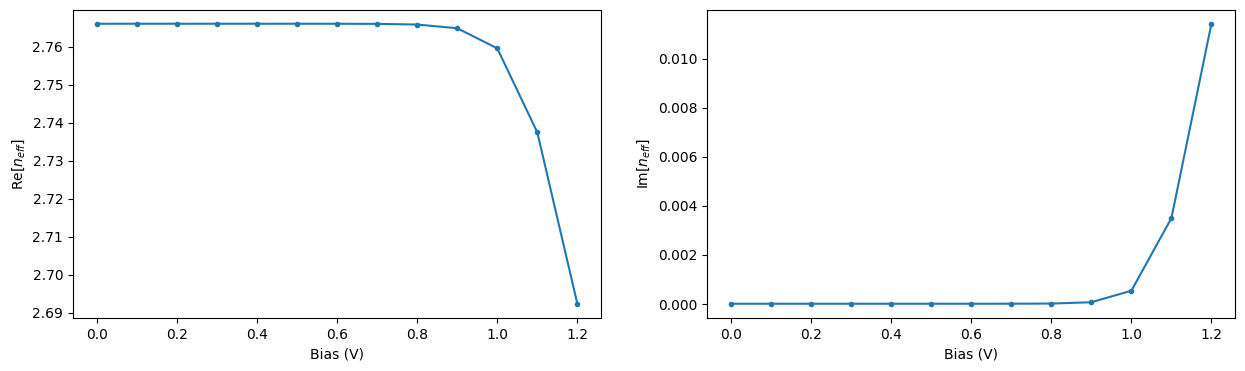

In [32]:
n_eff_freq0 = [md.n_complex.sel(f=freq0, mode_index=0).values for md in ms_data]

_, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].plot(voltages, np.real(n_eff_freq0), ".-")

ax[0].set_xlabel("Bias (V)")
ax[0].set_ylabel("Re[$n_{eff}$]")

ax[1].plot(voltages, np.imag(n_eff_freq0), ".-")

ax[1].set_xlabel("Bias (V)")
ax[1].set_ylabel("Im[$n_{eff}$]")

plt.show()

Using the obtained propagation index values we can compute the associated phase change and loss over the PIN section of the modulator at the central wavelength of 1.55 um. From this information we can estimate the bias $V_\pi$ required for a phase shift of $\pi$ to be around 0.95 V. In [Zhou Liang et al 2011 Chinese Phys. Lett. 28 074202](https://doi.org/10.1088/0256-307X/28/7/074202) the value of 1.15 V was obtained for a similar experimental setup.

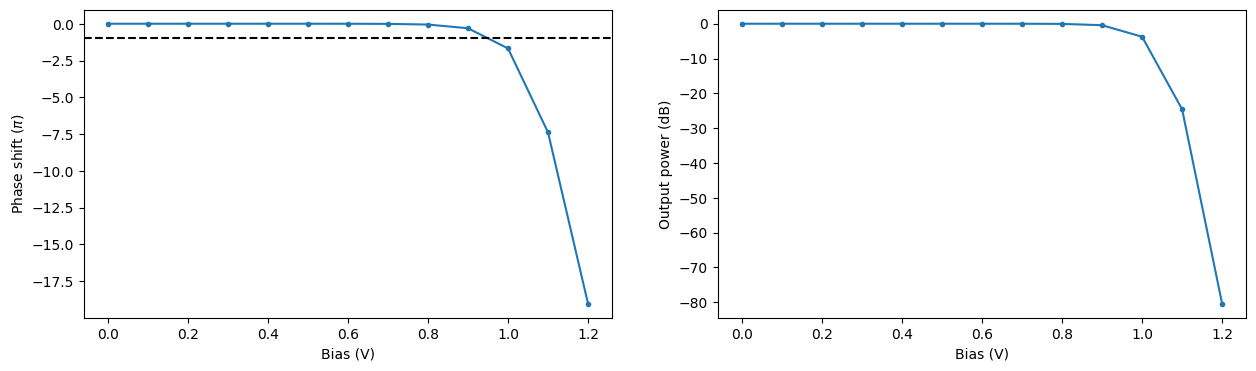

In [33]:
phase_shift = 2 * np.pi / wvl_um * (np.real(n_eff_freq0) - np.real(n_eff_freq0[0])) * pin_length
intensity = np.exp(-4 * np.pi * np.imag(n_eff_freq0) * pin_length / wvl_um)

_, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].plot(voltages, phase_shift / np.pi, ".-")
ax[0].axhline(y=-1, color="k", linestyle="--")

ax[0].set_xlabel("Bias (V)")
ax[0].set_ylabel("Phase shift ($\pi$)")

ax[1].plot(voltages, 10 * np.log10(intensity), ".-")

ax[1].set_xlabel("Bias (V)")
ax[1].set_ylabel("Output power (dB)")

plt.show()

### Full-wave simulation of the circuit

**Note: the cost of running this section is over 15 FlexCredits.**

While performing full-wave simulations is not the most cost effective approach for such a simple geometry, we still perform it here for zero and 1 V bias values for demonstration purposes. Alternatively, one could achieve the full-wave simulation accuracy by diving the problem setup into smaller components and obtaining S-matrix for each of them using Tidy3D's [ComponentModeler](https://www.flexcompute.com/tidy3d/examples/notebooks/SMatrix/) plugin. Here, we simply perform simulation over the entire circuit.

For a clearer demonstration let us obtain free carrier distribution for the approximately found $V_\pi$ of 0.95 V.

In [34]:
%%capture
devsim.reset_devsim()

electrons_data, holes_data = solve_charge(
    w_core=w_core, 
    h_core=h_core, 
    h_slab=h_slab, 
    h_side=h_side, 
    w_contact=[w_contact, w_contact], 
    h_contact=h_contact,
    x_side=[-x_side, x_side], 
    x_total=[-x_total, x_total], 
    x_i=[-x_i, x_i], 
    x_p=[-x_p, x_p], 
    conc_p=conc_p,
    conc_pp=conc_pp,
    conc_n=conc_n,
    conc_nn=conc_nn,
    voltages=np.linspace(0, 0.95, 10),
    res=res,
    center=[0, wg_spacing / 2, 0],
    axis=0,
)

In [35]:
perturbed_sim_0_95V = apply_charge([electrons_data[-1]], [holes_data[-1]])[0]

For convenience, we use `Batch` functionality to submit two simulation for solving in parallel.

In [36]:
batch = web.Batch(simulations={f"Bias: 0 V": perturbed_sims[0], f"Bias: 0.95 V": perturbed_sim_0_95V})
batch_data = batch.run()

15:09:03 CST Created task 'Bias: 0 V' with task_id                              
             'fdve-a5eac9e0-b780-47d8-b955-0f4077bd6bd9' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=411082;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a5eac9e0-b780-47d8-b955-0f4077bd6bd9\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=239514;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a5eac9e0-b780-47d8-b955-0f4077bd6bd9\taskId]8;;\]8;id=411082;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a5eac9e0-b780-47d8-b955-0f4077bd6bd9\=]8;;\]8;id=430813;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a5eac9e0-b780-47d8-b955-0f4077bd6bd9\fdve]8;;\]8;id=411082;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a5eac9e0-b780-47d8-b955-0f4077bd6bd9\-a5eac9e0-b78]8;;\
             ]8;id=411082;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a5eac9e0-b780-47d8-b955-0f4077bd6bd9\0-47d8-b955-0f4077bd6bd9']8;;\.

Output()

15:09:08 CST Created task 'Bias: 0.95 V' with task_id                           
             'fdve-de816538-3888-4d28-b7c5-d686dcd08e67' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=659116;https://tidy3d.simulation.cloud/workbench?taskId=fdve-de816538-3888-4d28-b7c5-d686dcd08e67\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=166795;https://tidy3d.simulation.cloud/workbench?taskId=fdve-de816538-3888-4d28-b7c5-d686dcd08e67\taskId]8;;\]8;id=659116;https://tidy3d.simulation.cloud/workbench?taskId=fdve-de816538-3888-4d28-b7c5-d686dcd08e67\=]8;;\]8;id=115794;https://tidy3d.simulation.cloud/workbench?taskId=fdve-de816538-3888-4d28-b7c5-d686dcd08e67\fdve]8;;\]8;id=659116;https://tidy3d.simulation.cloud/workbench?taskId=fdve-de816538-3888-4d28-b7c5-d686dcd08e67\-de816538-388]8;;\
             ]8;id=659116;https://tidy3d.simulation.cloud/workbench?taskId=fdve-de816538-3888-4d28-b7c5-d686dcd08e67\8-4d28-b7c5-d686dcd08e67']8;;\.

Output()

15:09:15 CST Started working on Batch.

15:09:39 CST Maximum FlexCredit cost: 25.187 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

15:18:49 CST Batch complete.

Let us first visualize the field distribution across the whole circuit. Comparing the two simulations, one can qualitatively observe two effects:
1) power in the output waveguide is drastically changed as bias value of 0.95 V is close to $V_\pi$,
2) the signal strength visibly decreases along the PIN section of the modulator in the case of 0.95 V bias value due to losses associated with the increased concentration of free carriers.

Note that unequal aspect ratio is used for plotting.

Output()

14:54:00 CST loading simulation from                                            
             ./fdve-568cc481-e716-4dd6-b8d0-d827cc8e9afa.hdf5

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             loading simulation from                                            
             ./fdve-568cc481-e716-4dd6-b8d0-d827cc8e9afa.hdf5

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

Output()

14:54:11 CST loading simulation from                                            
             ./fdve-ef90389a-6f44-4791-a813-1b126979bd7e.hdf5

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             loading simulation from                                            
             ./fdve-ef90389a-6f44-4791-a813-1b126979bd7e.hdf5

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

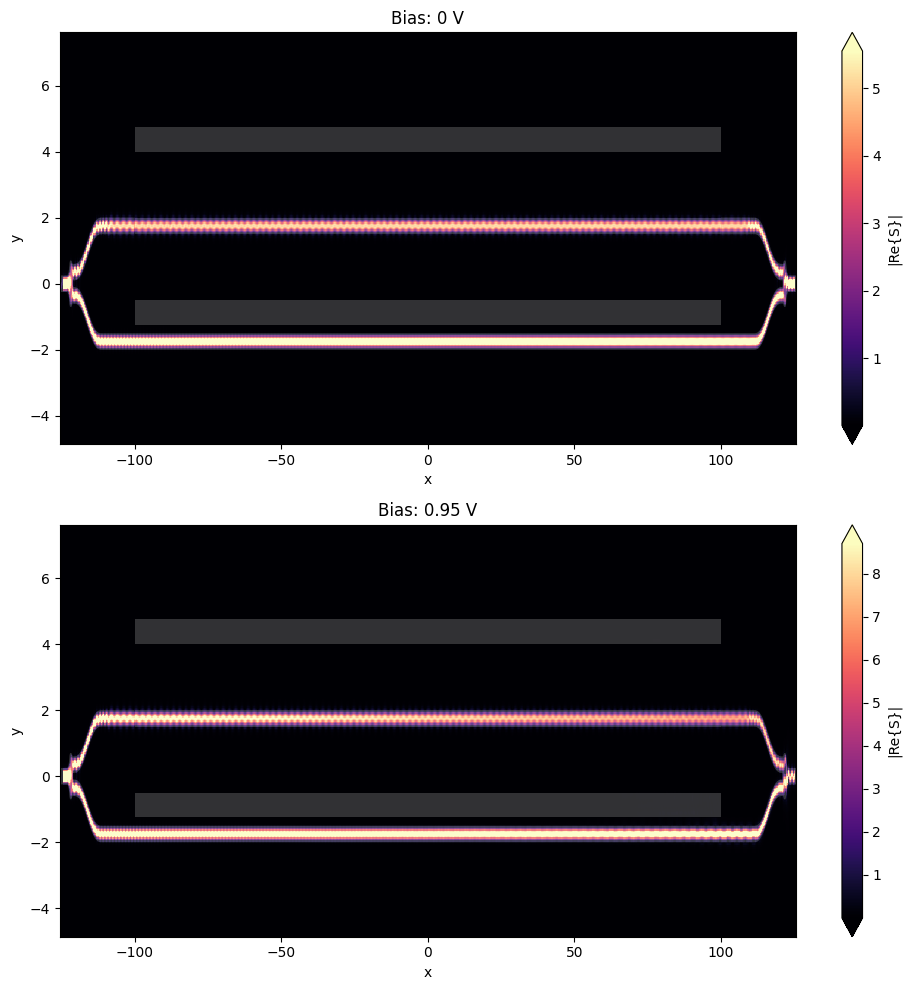

In [36]:
_, ax = plt.subplots(2, 1, figsize=(10, 10))

for ind, (key, data) in enumerate(batch_data.items()):
    batch_data[key].plot_field("field", "S", ax=ax[ind])
    ax[ind].set_title(key)
    ax[ind].set_aspect("auto")

plt.tight_layout()
plt.show()

A more quantitative visualization of data can be obtained from the output `ModeMonitor` results.

14:54:14 CST loading simulation from                                            
             ./fdve-568cc481-e716-4dd6-b8d0-d827cc8e9afa.hdf5

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             loading simulation from                                            
             ./fdve-568cc481-e716-4dd6-b8d0-d827cc8e9afa.hdf5

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             loading simulation from                                            
             ./fdve-ef90389a-6f44-4791-a813-1b126979bd7e.hdf5

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             loading simulation from                                            
             ./fdve-ef90389a-6f44-4791-a813-1b126979bd7e.hdf5

14:54:15 CST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

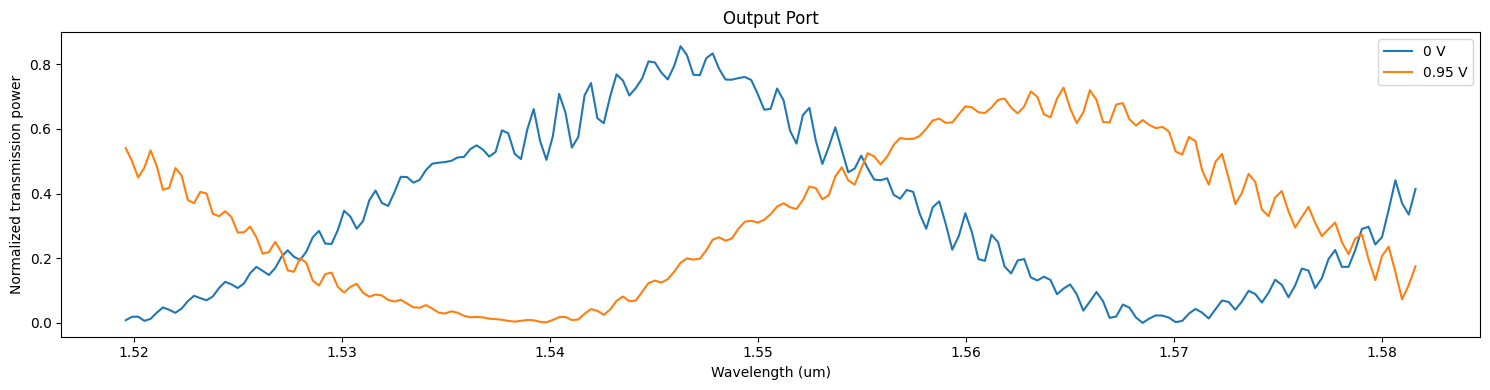

In [37]:
_, ax = plt.subplots(1, 1, figsize=(15, 4))
for ind, (key, data) in enumerate(batch_data.items()):
    ax.plot(wvls, batch_data[key]["out"].amps.sel(direction="+", mode_index=0).abs ** 2)

ax.set_title("Output Port")
ax.set_xlabel("Wavelength (um)")
ax.set_ylabel("Normalized transmission power")
ax.legend(["0 V", "0.95 V"])

plt.tight_layout()
plt.show()